In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-box-office-prediction/train.csv
/kaggle/input/tmdb-box-office-prediction/test.csv


**Importing modules**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import eli5
import lightgbm as lgb

pd.set_option('display.max_columns', None)
from collections import Counter
from wordcloud import WordCloud
%matplotlib inline
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings('ignore')

**Read train and test data**

In [3]:
train = pd.read_csv("/kaggle/input/tmdb-box-office-prediction/train.csv")
test = pd.read_csv("/kaggle/input/tmdb-box-office-prediction/test.csv")

In [4]:
print("Shape of train data : ", train.shape)
print("Shape of test data : ", test.shape)

Shape of train data :  (3000, 23)
Shape of test data :  (4398, 22)


In [5]:
train.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


We have given data in string format for accessing value by key it's important to convert string into dictionary

In [6]:
# Convert string columns to dictionary
json_columns = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df, json_columns = json_columns):
    for col in json_columns:
        df[col] = df[col].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

train = text_to_dict(train)
test = text_to_dict(test)

**belongs_to_collection**

In [7]:
train['belongs_to_collection'][:3]

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                   {}
Name: belongs_to_collection, dtype: object

In [8]:
train['belongs_to_collection'].apply(lambda x: len(x) if x!={} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [9]:
train['collection'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x!={} else 0)
train['has_collection'] = train['collection'].apply(lambda x: 1 if x!=0 else 0)

test['collection'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x!={} else 0)
test['has_collection'] = test['collection'].apply(lambda x: 1 if x!=0 else 0)

train.drop(['belongs_to_collection'], axis=1, inplace=True)
test.drop(['belongs_to_collection'], axis=1, inplace=True)

**Genres**

In [10]:
train['genres'][:3]

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
Name: genres, dtype: object

In [11]:
train['genres'].apply(lambda x: len(x) if x!={} else 0).value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

most of movie have 1 to 5 genre but there is also exist some movie that have more then 5 genre so may be thay can be outlier.

In [12]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x!={} else 0)
list_of_genres = list(train['genres'].apply(lambda x: [j['name'] for j in x] if x!={} else []).values)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join([j['name'] for j in x]) if x!={} else "" )

top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genres_'+g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)


test['num_genres'] = test['genres'].apply(lambda x: len(x) if x!={} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join([j['name'] for j in x]) if x!={} else "" )

for g in top_genres:
    test['genres_'+g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)


Here we made special category for most common 15 genre and assign 1 if movie belongs to that genre else 0

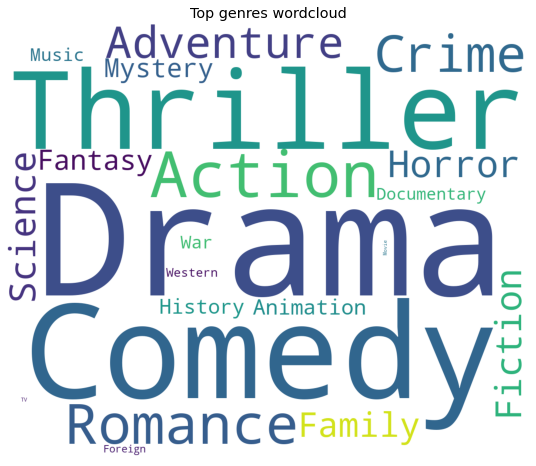

In [13]:
plt.figure(figsize=(12, 8))
text = ' '.join(i for j in list_of_genres for i in j)
img = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.title('Top genres wordcloud')
plt.axis("off")
plt.imshow(img)
plt.show()

Based on wordcloud we can say that most of the movie belongs to Drama, comedy and thriller genre.

**production_companies**

Number of production companies involved for making one movie

In [14]:
train['production_companies'].apply(lambda x: len(x) if x!={} else 0).value_counts()

1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
10      7
11      7
12      3
15      2
16      2
13      1
14      1
17      1
Name: production_companies, dtype: int64

In [15]:
train['production_companies'].head(2)

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
Name: production_companies, dtype: object

In [16]:
train['num_production_companies'] = train['production_companies'].apply(lambda x: len(x) if x!={} else 0)
list_of_pc = train['production_companies'].apply(lambda x: [i['name'] for i in x] if x!={} else []).values
train['all_production_companies'] = train['production_companies'].apply(lambda x : ' '.join( i['name'] for i in x ) if x!={} else "" )

top_pc = [m[0] for m in Counter(i for j in list_of_pc for i in j).most_common(15)]
for g in top_pc:
    train['production_companies_' + g] = train['all_production_companies'].apply(lambda x:1 if g in x else 0)



test['num_production_companies'] = test['production_companies'].apply(lambda x: len(x) if x!={} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x : ' '.join( i['name'] for i in x ) if x!={} else "" )

for g in top_pc:
    test['production_companies_' + g] = test['all_production_companies'].apply(lambda x:1 if g in x else 0)

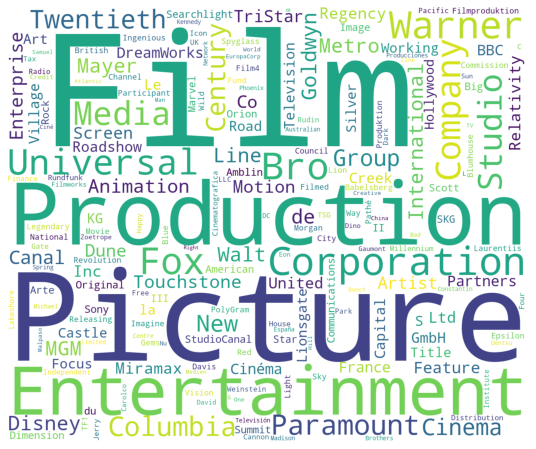

In [17]:
plt.figure(figsize=(12, 8))
text = ' '.join(i for j in list_of_pc for i in j)
img = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.axis('off')
plt.imshow(img)
plt.show()

**Production Countries**

In [18]:
train['production_countries'][:2]

0    [{'iso_3166_1': 'US', 'name': 'United States o...
1    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

In [19]:
train['production_countries'].apply(lambda x: len(x) if x!={} else 0).value_counts()

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

In data there exist some movie that does not belongs to any country so we can say those are outliers.

In [20]:
train['num_production_countries'] = train['production_countries'].apply(lambda x: len(x) if x!={} else 0)
list_of_prod_countries = train['production_countries'].apply(lambda x: [i['name'] for i in x]  if x!={} else []).values
train['all_production_countries'] = train['production_countries'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else "")
top_production_countries = [m[0] for m in Counter([i for j in list_of_prod_countries for i in j]).most_common(15)]

for g in top_production_countries:
    train['production_countries_' + g] = train['all_production_countries'].apply(lambda x: 1 if g in x else 0)
    

test['num_production_countries'] = test['production_countries'].apply(lambda x: len(x) if x!={} else 0)
test['all_production_countries'] = test['production_countries'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else "")

for g in top_production_countries:
    test['production_countries_' + g] = test['all_production_countries'].apply(lambda x: 1 if g in x else 0)

In [21]:
for i, j in Counter([i for j in list_of_prod_countries for i in j]).most_common(10):
    print(i,(30-len(i))*" ", j/len(list_of_prod_countries)*100)

United States of America        76.06666666666668
United Kingdom                  12.666666666666668
France                          7.3999999999999995
Germany                         5.566666666666667
Canada                          4.0
India                           2.7
Italy                           2.1333333333333333
Japan                           2.033333333333333
Australia                       2.033333333333333
Russia                          1.9333333333333333


US involved as production country in more than 76% movie

**Spoken language**

In [22]:
train['spoken_languages'].apply(lambda x: len(x) if x!={} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [23]:
train['num_spoken_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x!={} else 0)
list_of_spoken_languages = train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x!={} else "").values
train['all_spoken_languages'] = train['spoken_languages'].apply(lambda x: [' '.join(i['name'] for i in x)] if x!={} else [] )
top_spoken_languages = [m[0] for m in Counter(i for j in list_of_spoken_languages for i in j).most_common(15)]

for g in top_spoken_languages:
    train['spoken_language_'+g] = train['all_spoken_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_spoken_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x!={} else 0)
test['all_spoken_languages'] = test['spoken_languages'].apply(lambda x: [' '.join(i['name'] for i in x)] if x!={} else [] )

for g in top_spoken_languages:
    test['spoken_language_'+g] = test['all_spoken_languages'].apply(lambda x: 1 if g in x else 0)

In [24]:
for i,j in Counter([i for j in list_of_spoken_languages for i in j]).most_common(10):
    print(i, (70-len(i))*" ", round(j*100/len(list_of_spoken_languages), 2))

English                                                                 87.27
Français                                                                9.6
Español                                                                 7.97
Deutsch                                                                 5.63
Pусский                                                                 5.07
Italiano                                                                4.13
日本語                                                                     2.97
普通话                                                                     2.27
हिन्दी                                                                  1.87
                                                                        1.57


in 87% of the movie spoken language is english

**Keywords**

In [25]:
train['Keywords'][:2]

0    [{'id': 4379, 'name': 'time travel'}, {'id': 9...
1    [{'id': 2505, 'name': 'coronation'}, {'id': 42...
Name: Keywords, dtype: object

In [26]:
train['Keywords'].apply(lambda x: len(x) if x!={} else 0).value_counts().head(10)

5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

In [27]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x!={} else 0)
list_of_Keywords = train['Keywords'].apply(lambda x: [i['name'] for i in x] if x!={} else []).values
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else "")
top_Keywords = [m[0] for m in Counter(i for j in list_of_Keywords for i in j).most_common(30)]

for g in top_Keywords:
    train['Keywords_'+g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x!={} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else "")

for g in top_Keywords:
    test['Keywords_'+g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

In [28]:
for i,j in Counter([i for j in list_of_Keywords for i in j]).most_common(20):
    print(i, (50 - len(i))*" ", j)

woman director                                      175
independent film                                    155
duringcreditsstinger                                134
murder                                              123
based on novel                                      111
violence                                            87
sport                                               82
biography                                           77
aftercreditsstinger                                 75
dystopia                                            73
revenge                                             73
friendship                                          72
sex                                                 71
suspense                                            67
sequel                                              66
love                                                64
police                                              64
teenager                                            61
nudit

Most occuring keywords are woman director, independent film, duringcreditsstinger, murder and based on novel

**Cast**

In [29]:
train['cast'][:2]

0    [{'cast_id': 4, 'character': 'Lou', 'credit_id...
1    [{'cast_id': 1, 'character': 'Mia Thermopolis'...
Name: cast, dtype: object

In [30]:
train['cast'].apply(lambda x:len(x) if x!={} else 0).value_counts()

15     212
16     165
10     135
13     129
12     124
      ... 
156      1
122      1
87       1
108      1
92       1
Name: cast, Length: 109, dtype: int64

In [31]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x!={} else 0)
list_of_cast = train['cast'].apply(lambda x: [i['name'] for i in x] if x!={} else []).values
train['all_cast'] = train['cast'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else "")

top_cast = [m[0] for m in Counter([i for j in list_of_cast for i in j]).most_common(20)]

for g in top_cast:
    train['cast_name_'+g] = train['all_cast'].apply(lambda x: 1 if g in x else 0)
    

test['num_cast'] = test['cast'].apply(lambda x: len(x) if x!={} else 0)
test['all_cast'] = test['cast'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else "")

for g in top_cast:
    test['cast_name_'+g] = test['all_cast'].apply(lambda x: 1 if g in x else 0)

Most popular popular cast and number of movies they are in

In [32]:
for i, j in Counter([i for j in list_of_cast for i in j]).most_common(15):
    print(i, (50-len(i))*" ", j)

Samuel L. Jackson                                   30
Robert De Niro                                      30
Morgan Freeman                                      27
J.K. Simmons                                        25
Bruce Willis                                        25
Liam Neeson                                         25
Susan Sarandon                                      25
Bruce McGill                                        24
John Turturro                                       24
Forest Whitaker                                     23
Willem Dafoe                                        23
Bill Murray                                         22
Owen Wilson                                         22
Nicolas Cage                                        22
Sylvester Stallone                                  21


In [33]:
list_of_gender = train['cast'].apply(lambda x: [i['gender'] for i in x] if x!={} else [])
Counter([i for j in list_of_gender for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

In [34]:
train['gender_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['gender_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['gender_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

test['gender_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['gender_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['gender_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

Here we just assigned number of gender in total cast for particular one movie like number of male for x movie from all x cast

In [35]:
list_of_characters = train['cast'].apply(lambda x: [i['character'] for i in x] if x!={} else [])
Counter(i for j in list_of_characters for i in j).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

For cast character there are lot of people who play himself/ herself in movie

In [36]:
train['num_cast_characters'] = train['cast'].apply(lambda x: len(x) if x!={} else 0)
train['all_cast_character'] = train['cast'].apply(lambda x: " ".join(i['character'] for i in x) if x!={} else "")
top_cast_characters = [m[0] for m in Counter(i for j in list_of_characters for i in j).most_common(20)]
for g in top_cast_characters:
    train['cast_character_'+g] = train['all_cast_character'].apply(lambda x: 1 if g in x else 0)

test['num_cast_characters'] = test['cast'].apply(lambda x: len(x) if x!={} else 0)
test['all_cast_character'] = test['cast'].apply(lambda x: " ".join(i['character'] for i in x) if x!={} else "")
for g in top_cast_characters:
    test['cast_character_'+g] = test['all_cast_character'].apply(lambda x: 1 if g in x else 0)

**Crew**

In [37]:
train['crew'].apply(lambda x: len(x) if x!={} else 0).value_counts().head(10), train['crew'].apply(lambda x: len(x) if x!={} else 0).value_counts().tail(10)

(2     179
 11    127
 10    126
 3     126
 12    110
 8     109
 9     109
 14    104
 4     101
 7      94
 Name: crew, dtype: int64,
 194    1
 126    1
 172    1
 161    1
 96     1
 79     1
 142    1
 113    1
 94     1
 154    1
 Name: crew, dtype: int64)

Usually there is 2 to 15 crew but there are also exist some data that have more then 100 crew

In [38]:
list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [39]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x!={} else 0)
train['all_crew_name'] = train['crew'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else [])
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]

for g in top_crew_names:
    train['crew_name_' + g] = train['all_crew_name'].apply(lambda x: 1 if g in x else 0)


test['num_crew'] = test['crew'].apply(lambda x: len(x) if x!={} else 0)
test['all_crew_name'] = test['crew'].apply(lambda x: ' '.join(i['name'] for i in x) if x!={} else [])

for g in top_crew_names:
    test['crew_name_' + g] = test['all_crew_name'].apply(lambda x: 1 if g in x else 0)

**Genders for crew**

In [40]:
list_of_gender = train['crew'].apply(lambda x: [i['gender'] for i in x] if x!={} else [])
Counter(i for j in list_of_gender for i in j).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

In [41]:
train['crew_gender_0'] = train['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 0))
train['crew_gender_1'] = train['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 0))
train['crew_gender_2'] = train['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 2))

test['crew_gender_0'] = test['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 0))
test['crew_gender_1'] = test['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 0))
test['crew_gender_2'] = test['cast'].apply(lambda x: sum(1 for i in x if i['gender'] == 2))

Here we just assigned number of gender in total crew for particular one movie like number of male for x movie from all x cast

Job of crew and number of jobs

In [42]:
list_of_jobs = train['crew'].apply(lambda x: [i['job'] for i in x] if x!={} else [])
Counter([i for j in list_of_jobs for i in j]).most_common(20)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970),
 ('Camera Operator', 925),
 ('Script Supervisor', 917),
 ('Hairstylist', 804),
 ('Visual Effects Supervisor', 765),
 ('Sound Effects Editor', 750)]

In [43]:
train['all_job'] = train['crew'].apply(lambda x: [i['job'] for i in x] if x!={} else [])
top_job = [m[0] for m in Counter([i for j in list_of_jobs for i in j]).most_common(20)]

for g in top_job:
    train['job_'+g] = train['all_job'].apply(lambda x: 1 if g in x else 0)

test['all_job'] = test['crew'].apply(lambda x: [i['job'] for i in x] if x!={} else [])

for g in top_job:
    test['job_'+g] = test['all_job'].apply(lambda x: 1 if g in x else 0)

**Data Visualization**

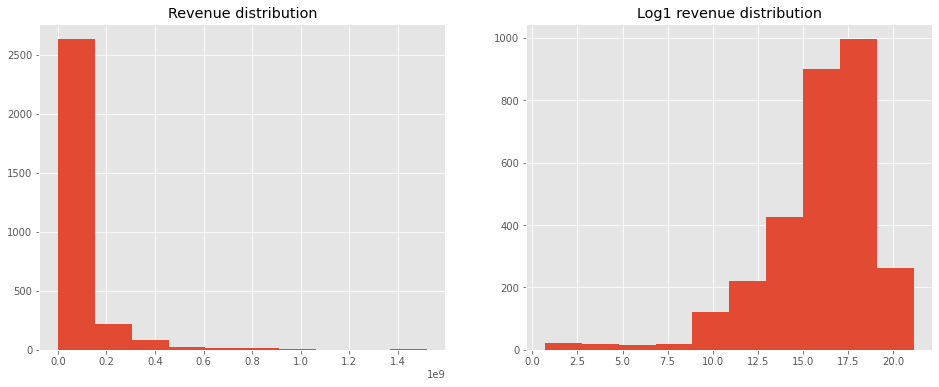

In [44]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist(train['revenue'])
plt.title("Revenue distribution")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']))
plt.title("Log1 revenue distribution")

plt.show()

When we apply log on revenue then it becomes less skewed and it will be better for our model

In [45]:
train['log_revenue'] = np.log1p(train['revenue'])

In [46]:
train['budget'].skew(), np.log1p(train['budget']).skew()

(3.1035303484688876, -0.9000651667922802)

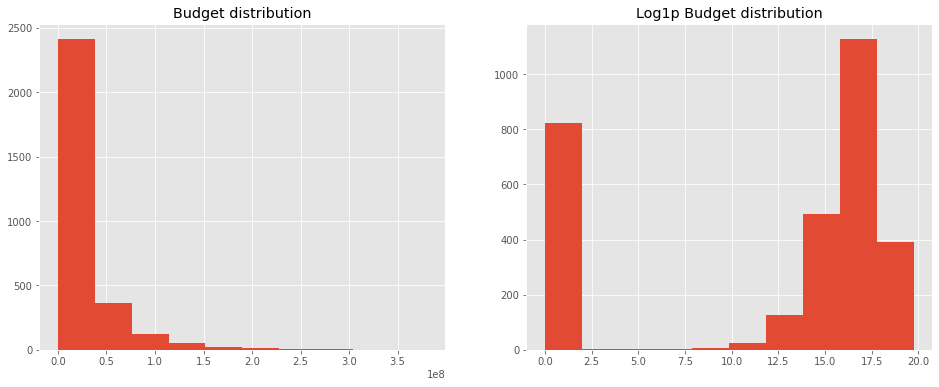

In [47]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))

plt.subplot(1,2,1)
plt.hist(train['budget'])
plt.title("Budget distribution")

plt.subplot(1,2,2)
plt.hist(np.log1p(train['budget']))
plt.title("Log1p Budget distribution")

plt.show()

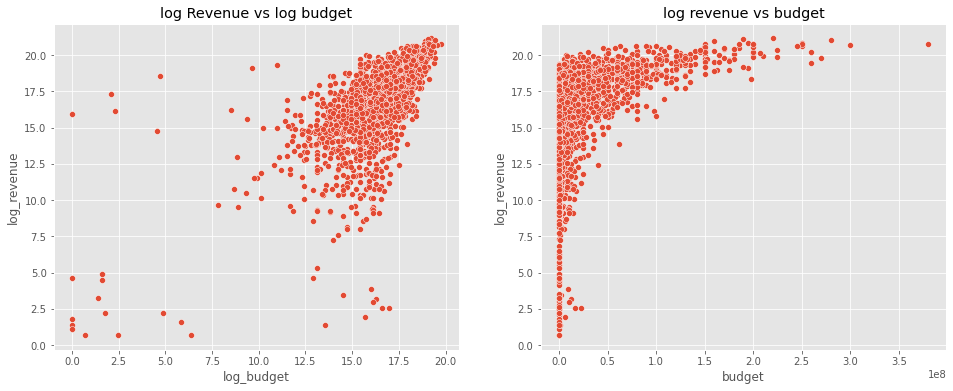

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x = np.log(train['budget']), y=train['log_revenue'])
plt.xlabel('log_budget')
plt.title("log Revenue vs log budget")

plt.subplot(1,2,2)
sns.scatterplot(x='budget', y='log_revenue', data=train)
plt.title("log revenue vs budget")

plt.show()

Scatter plot of log_revenue vs log_budget is very good as compared to log_revenue vs budget

In [49]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

In [50]:
train['homepage'].apply(lambda x: 1 if x!=np.nan else 0).value_counts()

1    3000
Name: homepage, dtype: int64

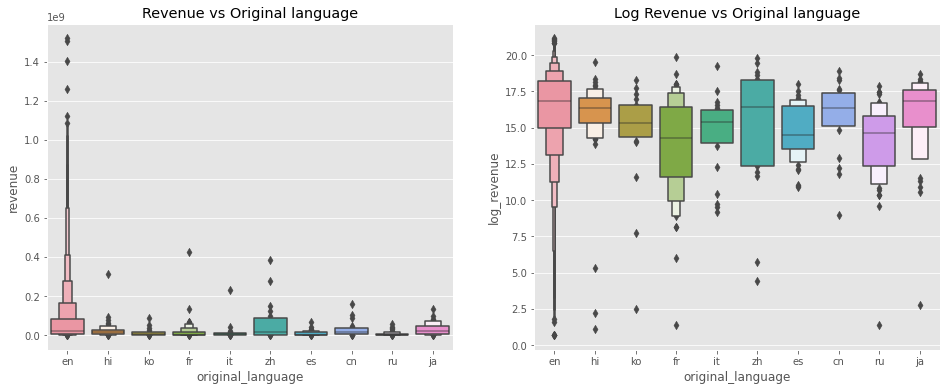

In [51]:
plt.subplots(1,2,figsize=(16, 6))
plt.subplot(1,2,1)
sns.boxenplot(x='original_language', y='revenue', data= train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)] )
plt.title("Revenue vs Original language")

plt.subplot(1,2,2)
sns.boxenplot(x='original_language', y='log_revenue', data= train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)] )
plt.title("Log Revenue vs Original language")

plt.show()

Based on previous three graph we can completely say that log_revenue is really good choice for our model as compared to revenue

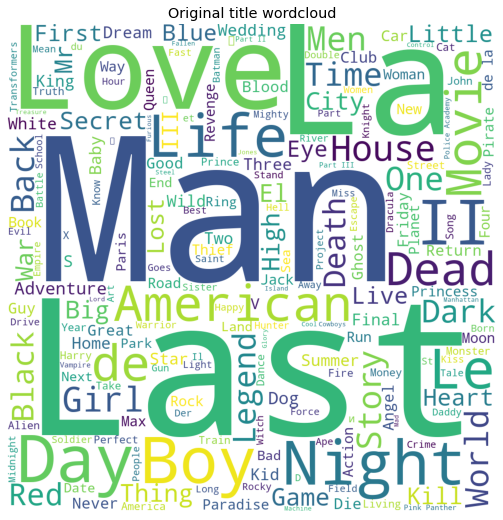

In [52]:
plt.figure(figsize=(9, 9))
title = ' '.join(train['original_title'].values)
img = WordCloud(width=1000, height=1000, background_color='white').generate(title)
plt.title("Original title wordcloud")
plt.imshow(img)
plt.axis('off')
plt.show()

Most occuring words in movie titles are Man and Last.

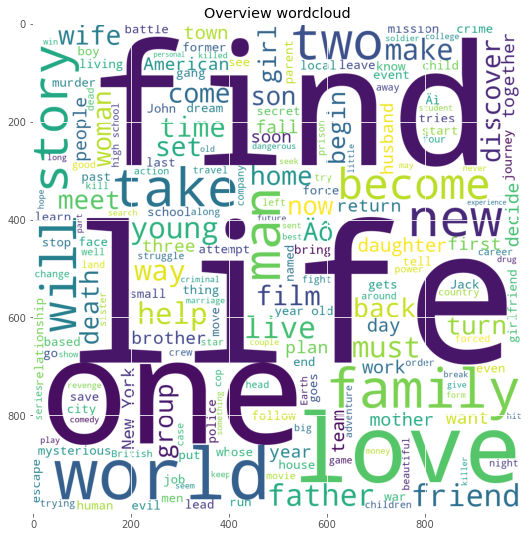

In [53]:
plt.figure(figsize=(9,9))
Overview = ' '.join(train['overview'].fillna(' ').values)
img = WordCloud(width=1000, height=1000, background_color='white').generate(Overview)
plt.imshow(img)
plt.title("Overview wordcloud")
plt.show()

Let's see impact of words on revenue

In [54]:
tfidf = TfidfVectorizer()

x = tfidf.fit_transform(train['overview'].fillna(''))
y = train['log_revenue']

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [55]:
mean_squared_error(lr.predict(X_valid), y_valid), mean_absolute_error(lr.predict(X_valid), y_valid)

(11.127289030573111, 2.4893194755991686)

In [56]:
eli5.show_weights(lr, vec=tfidf, top=20, feature_filter=lambda x: x != '<BIAS>')

In [57]:
print("Target value : ", train['log_revenue'][500])
eli5.show_prediction(lr, doc=train['overview'].values[500], vec = tfidf)

Target value :  13.516790456663609


**Popularity**

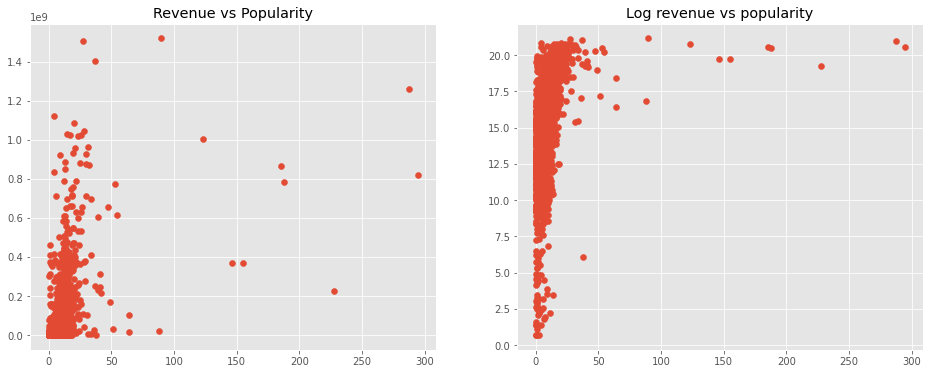

In [58]:
plt.subplots(1,2,figsize=(16, 6))

plt.subplot(1,2,1)
plt.scatter(x='popularity', y='revenue', data=train)
plt.title("Revenue vs Popularity")

plt.subplot(1,2,2)
plt.scatter(x='popularity', y='log_revenue', data=train)
plt.title("Log revenue vs popularity")

plt.show()

Based on scatter plot we can say revenue is not much dependent on popularity

**Release Date**

In [59]:
test[test.release_date.isnull()].index

Int64Index([828], dtype='int64')

In [60]:
test.at[828, 'release_date'] = '1/5/2000'

In [61]:
train['release_date_year'] = train['release_date'].apply(lambda x: 19*100 + int(x.split('/')[-1]) if int(x.split('/')[-1]) > 22 else 20*100 + int(x.split('/')[-1]))
test['release_date_year'] = test['release_date'].apply(lambda x: 19*100 + int(x.split('/')[-1]) if int(x.split('/')[-1]) > 22 else 20*100 + int(x.split('/')[-1]))

train['release_date_month'] = pd.to_datetime(train['release_date']).dt.month
test['release_date_month'] = pd.to_datetime(test['release_date']).dt.month

train['release_date_weekday'] = pd.to_datetime(train['release_date']).dt.weekday
test['release_date_weekday'] = pd.to_datetime(test['release_date']).dt.weekday

train['release_date_weekofyear'] = pd.to_datetime(train['release_date']).dt.weekofyear
test['release_date_weekofyear'] = pd.to_datetime(test['release_date']).dt.weekofyear

train['release_date_day'] = pd.to_datetime(train['release_date']).dt.day
test['release_date_day'] = pd.to_datetime(test['release_date']).dt.day

In [62]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()

data = [go.Scatter(x = d1.index, y=d1.values, name='train'), go.Scatter(x = d2.index, y = d2.values, name='test')]
layout = go.Layout(dict(title="Number of movies per year",
                  xaxis = dict(title="year"),
                  yaxis = dict(title="Count")),legend = dict(orientation='v'))
py.iplot(dict(data = data, layout=layout))

# d1 = train['release_date_year'].value_counts().sort_index()
# d2 = test['release_date_year'].value_counts().sort_index()
# data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
# layout = go.Layout(dict(title = "Number of films per year",
#                   xaxis = dict(title = 'Year'),
#                   yaxis = dict(title = 'Count'),
#                   ),legend=dict(
#                 orientation="v"))
# py.iplot(dict(data=data, layout=layout))

In [63]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [64]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby('release_date_year')['revenue'].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [65]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

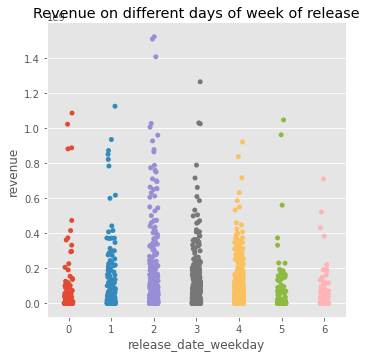

In [66]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

Films releases on Wednesdays and on Thursdays tend to have a higher revenue.

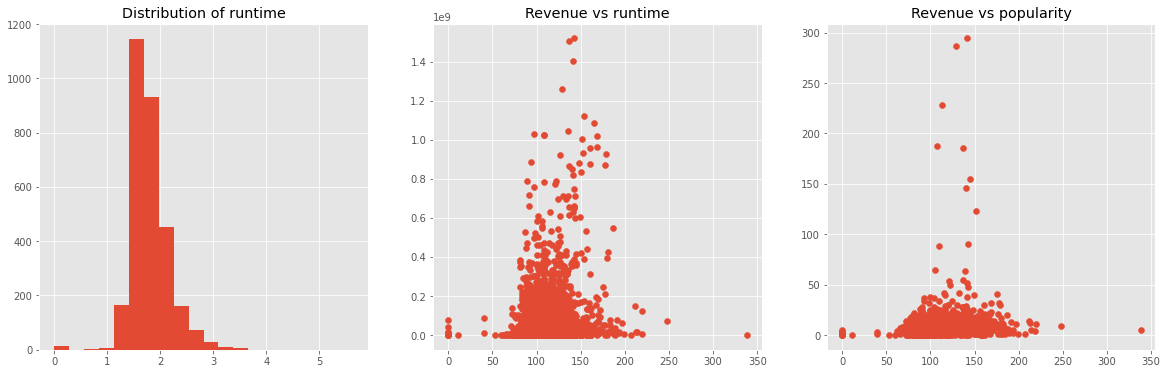

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

plt.subplot(1,3,1)
plt.hist(train['runtime'].fillna(0)/60, bins=20)
plt.title("Distribution of runtime")

plt.subplot(1,3,2)
plt.scatter(x = 'runtime', y='revenue', data=train)
plt.title("Revenue vs runtime")

plt.subplot(1,3,3)
plt.scatter(x = 'runtime', y='popularity', data=train)
plt.title("Revenue vs popularity")

plt.show()

In [68]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [69]:
test['status'].value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

**Tagline**

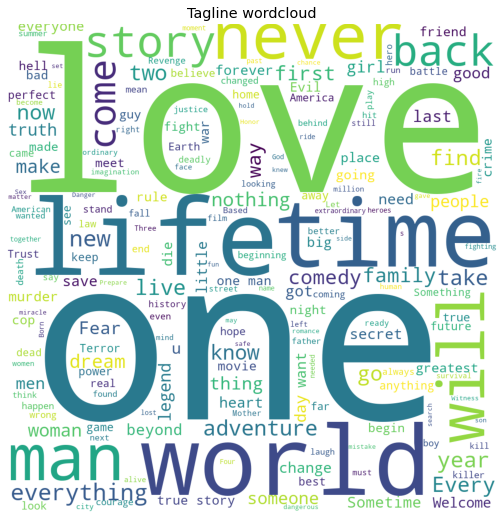

In [70]:
text = ' '.join(train['tagline'].fillna("").values)
img = WordCloud(width=1000, height=1000, background_color='white').generate(text)
plt.figure(figsize=(9, 9))
plt.imshow(img)
plt.title("Tagline wordcloud")
plt.axis("off")
plt.show()

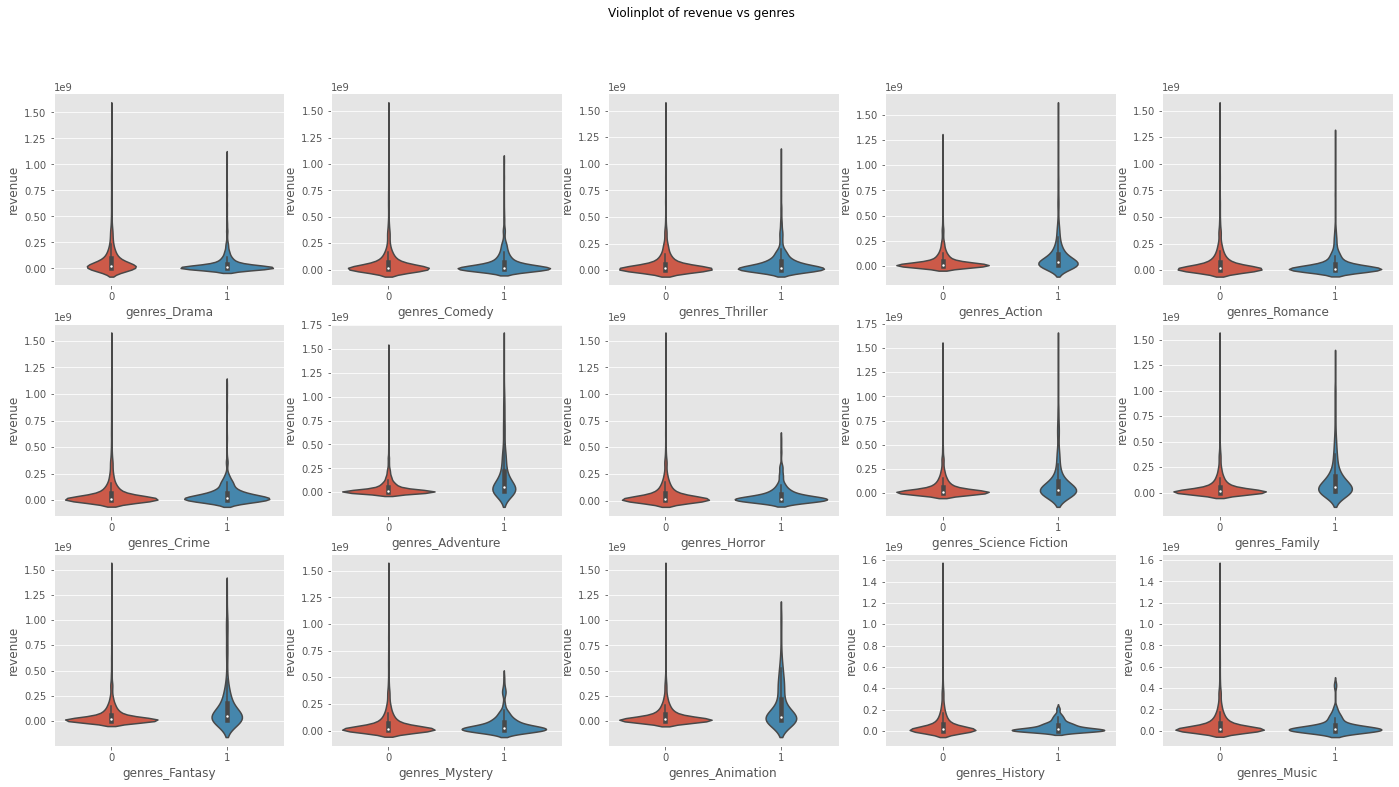

In [71]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genres_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

Family, adventure, fantasy and animation have high revenue

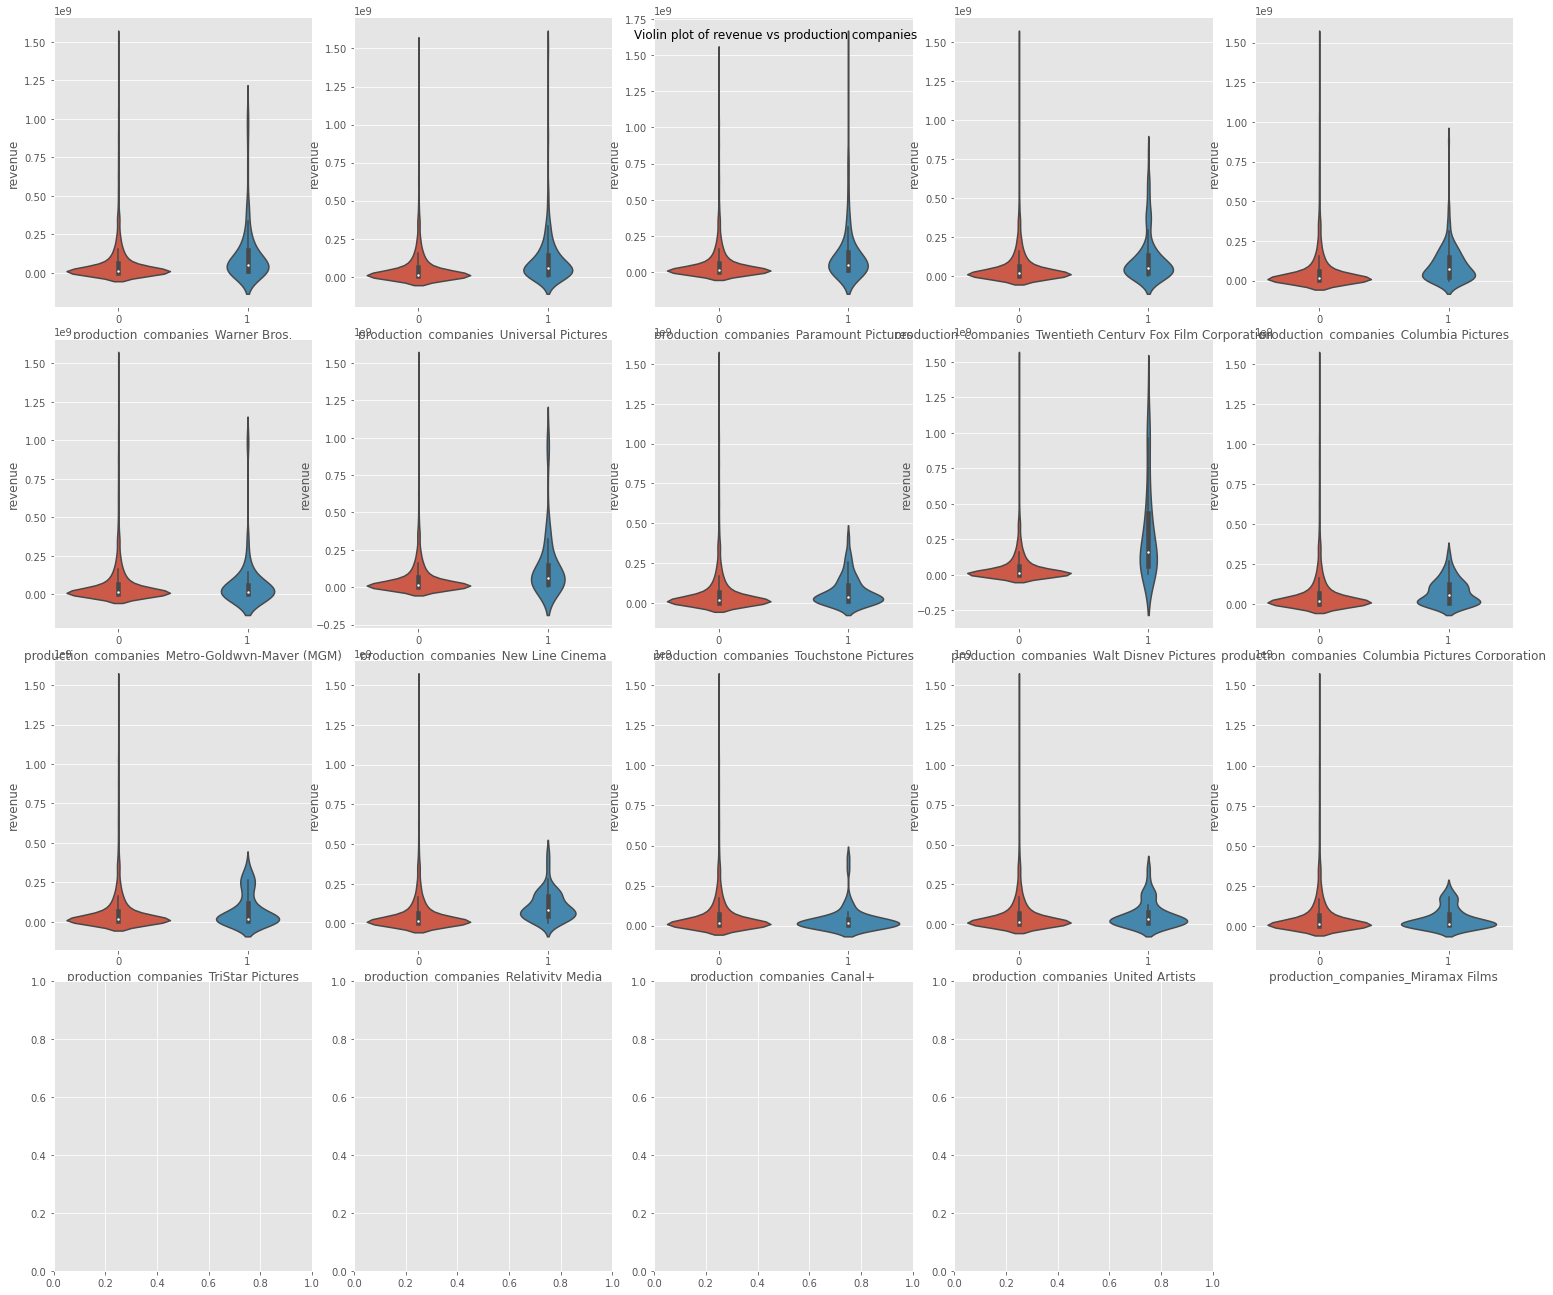

In [72]:
fig, ax = plt.subplots(4, 5, figsize=(21, 18))
fig.tight_layout()
plt.subplots_adjust(wspace=None, hspace=None)
plt.axis('off')
plt.suptitle("Violin plot of revenue vs production companies")
for i,e in enumerate([col for col in train.columns if 'production_companies_' in col]):
    sns.violinplot(x = e, y='revenue', data = train, ax = ax[i // 5][i % 5])

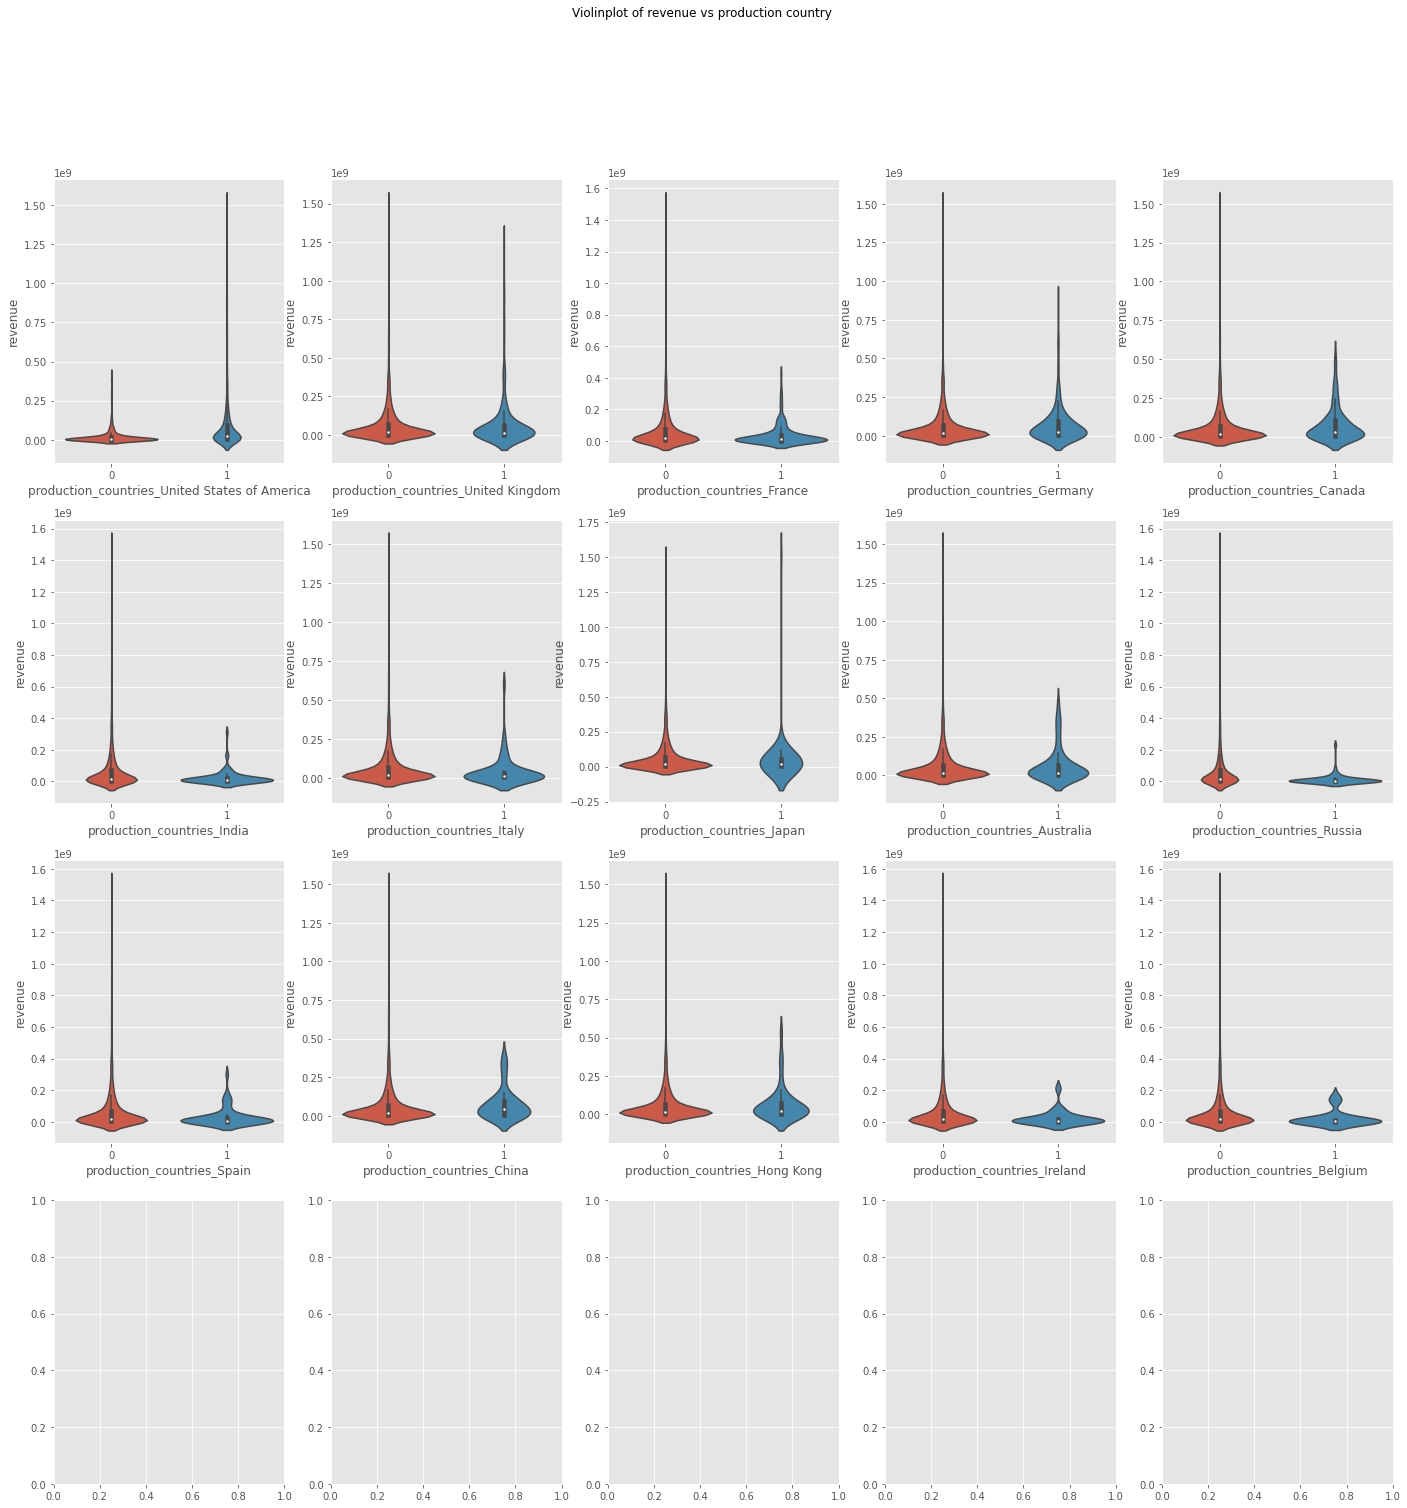

In [73]:
f, axes = plt.subplots(4, 5, figsize=(24, 24))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'production_countries_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

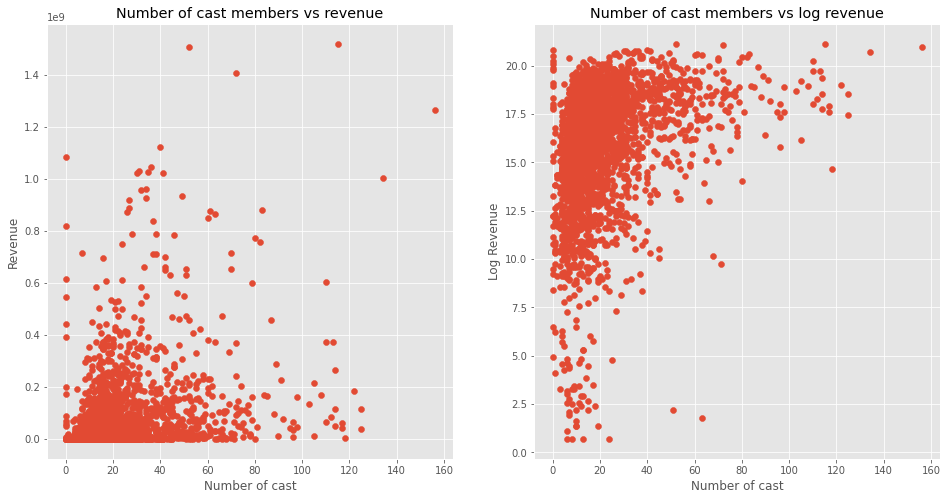

In [74]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'])
plt.title('Number of cast members vs revenue');
plt.xlabel("Number of cast")
plt.ylabel("Revenue")

plt.subplot(1, 2, 2)
plt.scatter(train['num_cast'], train['log_revenue'])
plt.title('Number of cast members vs log revenue');
plt.xlabel("Number of cast")
plt.ylabel("Log Revenue")

plt.show()

number of cast and log_revenue is positively correlated with eachother

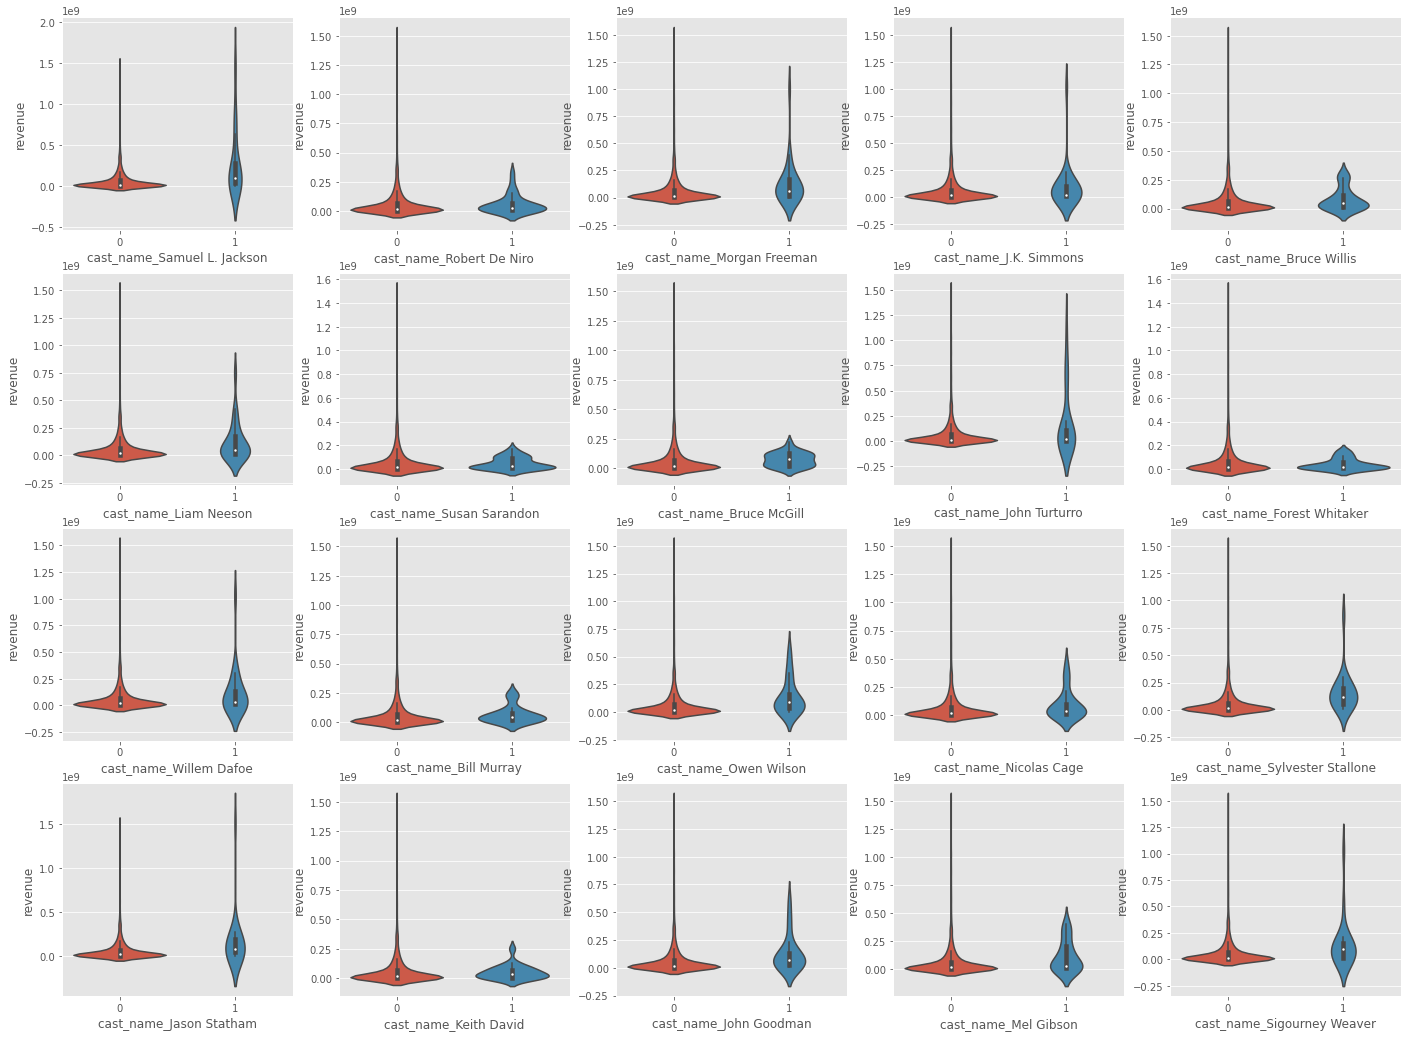

In [75]:
fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize=(24, 18))

for i,e in enumerate([col for col in train.columns if 'cast_name_' in col]):
    sns.violinplot(x = e, y = 'revenue', data= train, ax = ax[i//5][i%5])

In [76]:
len([col for col in train.columns if 'cast_character_' in col])

20

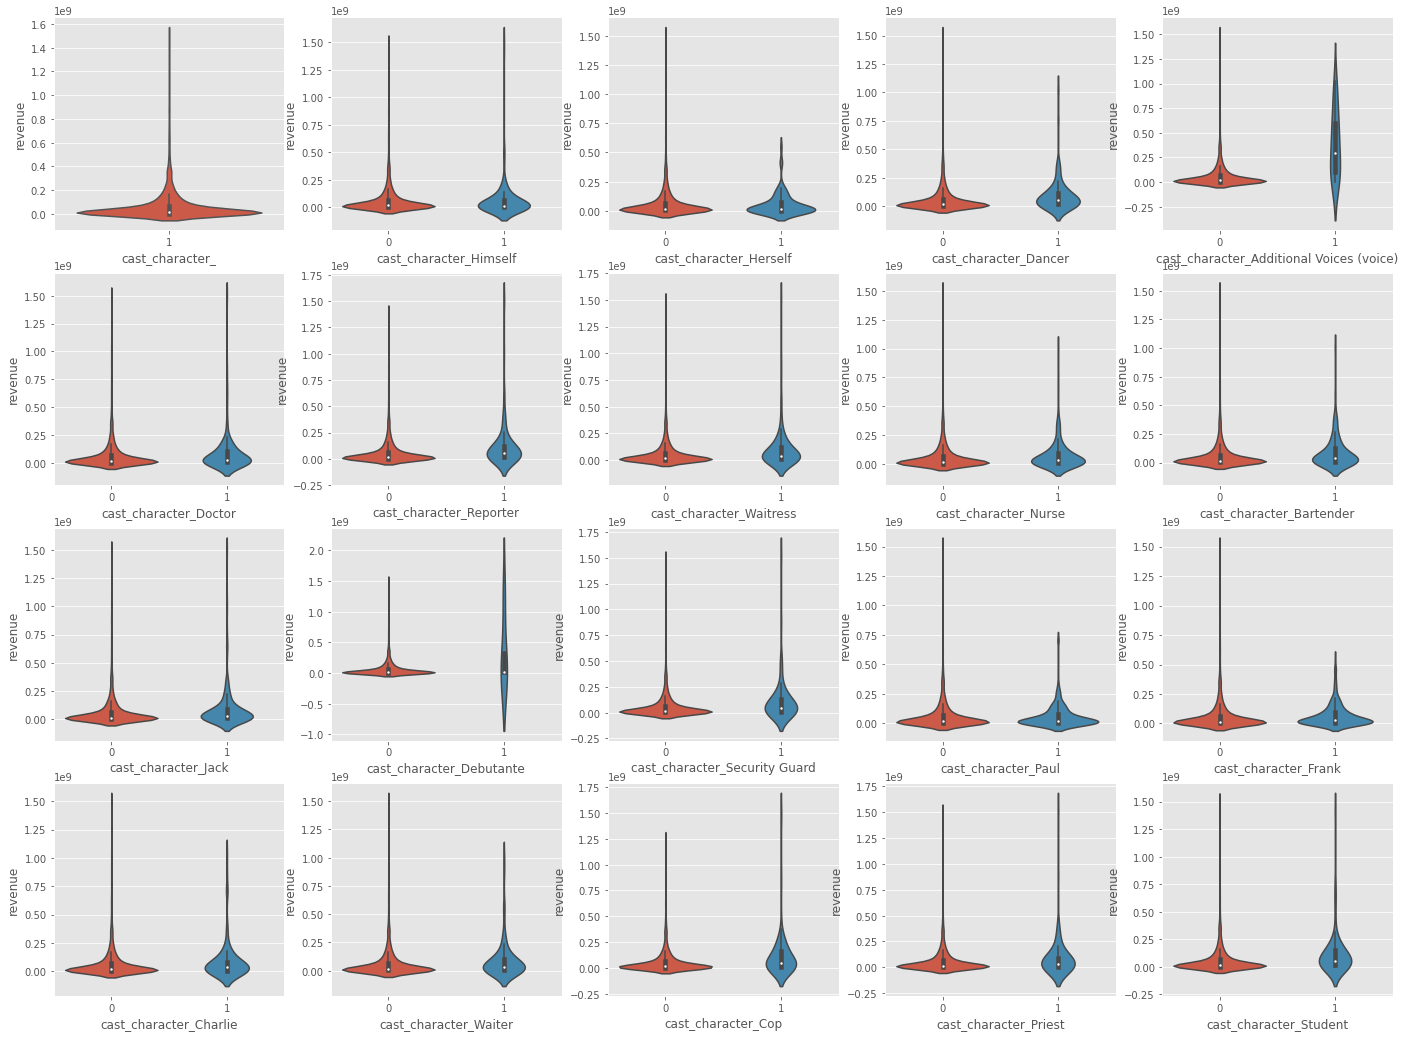

In [77]:
fig, ax = plt.subplots(4, 5, figsize=(24, 18))
for i,e in enumerate([col for col in train.columns if 'cast_character_' in col]):
    sns.violinplot(x = e, y = 'revenue', data=train, ax = ax[i//5][i%5])

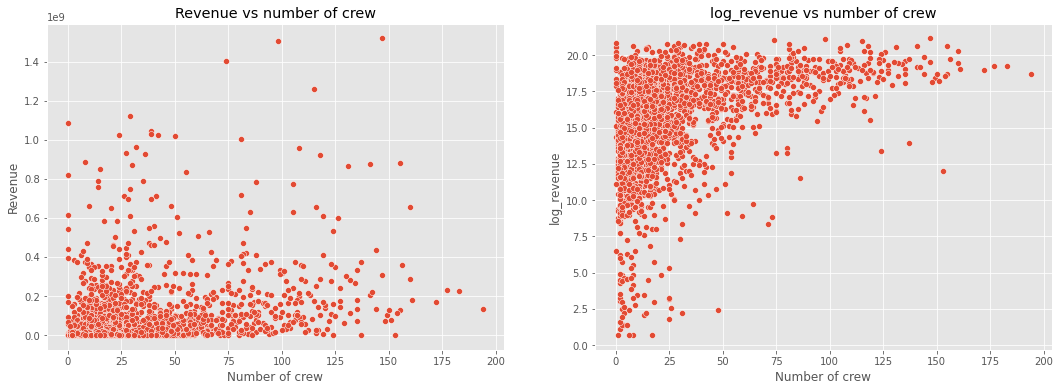

In [78]:
plt.subplots(1, 2, figsize=(18, 6))

plt.subplot(1,2,1)
sns.scatterplot(x = 'num_crew', y = 'revenue', data=train)
plt.title("Revenue vs number of crew")
plt.xlabel("Number of crew")
plt.ylabel("Revenue")

plt.subplot(1,2, 2)
sns.scatterplot(x = 'num_crew', y = 'log_revenue', data=train)
plt.title("log_revenue vs number of crew")
plt.xlabel("Number of crew")
plt.ylabel("log_revenue")

plt.show()

In [79]:
train.head(1)

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection,has_collection,num_genres,all_genres,genres_Drama,genres_Comedy,genres_Thriller,genres_Action,genres_Romance,genres_Crime,genres_Adventure,genres_Horror,genres_Science Fiction,genres_Family,genres_Fantasy,genres_Mystery,genres_Animation,genres_History,genres_Music,num_production_companies,all_production_companies,production_companies_Warner Bros.,production_companies_Universal Pictures,production_companies_Paramount Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Columbia Pictures,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Touchstone Pictures,production_companies_Walt Disney Pictures,production_companies_Columbia Pictures Corporation,production_companies_TriStar Pictures,production_companies_Relativity Media,production_companies_Canal+,production_companies_United Artists,production_companies_Miramax Films,num_production_countries,all_production_countries,production_countries_United States of America,production_countries_United Kingdom,production_countries_France,production_countries_Germany,production_countries_Canada,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Australia,production_countries_Russia,production_countries_Spain,production_countries_China,production_countries_Hong Kong,production_countries_Ireland,production_countries_Belgium,num_spoken_languages,all_spoken_languages,spoken_language_English,spoken_language_Français,spoken_language_Español,spoken_language_Deutsch,spoken_language_Pусский,spoken_language_Italiano,spoken_language_日本語,spoken_language_普通话,spoken_language_हिन्दी,spoken_language_,spoken_language_Português,spoken_language_العربية,spoken_language_한국어/조선말,spoken_language_广州话 / 廣州話,spoken_language_தமிழ்,num_Keywords,all_Keywords,Keywords_woman director,Keywords_independent film,Keywords_duringcreditsstinger,Keywords_murder,Keywords_based on novel,Keywords_violence,Keywords_sport,Keywords_biography,Keywords_aftercreditsstinger,Keywords_dystopia,Keywords_revenge,Keywords_friendship,Keywords_sex,Keywords_suspense,Keywords_sequel,Keywords_love,Keywords_police,Keywords_teenager,Keywords_nudity,Keywords_female nudity,Keywords_drug,Keywords_prison,Keywords_musical,Keywords_high school,Keywords_los angeles,Keywords_new york,Keywords_family,Keywords_father son relationship,Keywords_kidnapping,Keywords_investigation,num_cast,all_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,cast_name_Jason Statham,cast_name_Keith David,cast_name_John Goodman,cast_name_Mel Gibson,cast_name_Sigourney Weaver,gender_0_cast,gender_1_cast,gender_2_cast,num_cast_characters,all_cast_character,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,cast_character_Charlie,cast_character_Waiter,cast_character_Cop,cast_character_Priest,cast_character_Student,num_crew,all_crew_name,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James H

Here i deleted column that contains unique values and columns that i already took data from them

In [80]:
train.drop(['genres', 'homepage', 'imdb_id', 'poster_path', 'production_companies','production_countries','release_date', 'spoken_languages','status', 'Keywords','cast','crew', 'id'], axis=1, inplace=True)
test.drop(['genres', 'homepage', 'imdb_id', 'poster_path', 'production_companies','production_countries','release_date', 'spoken_languages','status', 'Keywords','cast','crew', 'id'], axis=1, inplace=True)

In [81]:
train['collection'] = train['collection'].apply(lambda x: str(x))
test['collection'] = test['collection'].apply(lambda x: str(x))

Using label encoder assign unique number to all unique values

In [82]:
for col in ['original_language', 'all_genres', 'collection']:
    lb = LabelEncoder()
    lb.fit(list(train[col].fillna("")) + list(test[col].fillna("")))
    train[col] = lb.transform(train[col].fillna(""))
    test[col] = lb.transform(test[col].fillna(""))

In [83]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

Again dropped unnecessary columns

In [84]:
train.drop(['all_production_companies', 'all_production_countries', 'all_spoken_languages', 'all_Keywords', 'all_cast', 'all_cast_character', 'all_crew_name', 'all_job'], axis=1, inplace=True)
test.drop(['all_production_companies', 'all_production_countries', 'all_spoken_languages', 'all_Keywords', 'all_cast', 'all_cast_character', 'all_crew_name', 'all_job'], axis=1, inplace=True)

In [85]:
train.head(2)

,budget,original_language,popularity,runtime,revenue,collection,has_collection,num_genres,all_genres,genres_Drama,genres_Comedy,genres_Thriller,genres_Action,genres_Romance,genres_Crime,genres_Adventure,genres_Horror,genres_Science Fiction,genres_Family,genres_Fantasy,genres_Mystery,genres_Animation,genres_History,genres_Music,num_production_companies,production_companies_Warner Bros.,production_companies_Universal Pictures,production_companies_Paramount Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Columbia Pictures,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Touchstone Pictures,production_companies_Walt Disney Pictures,production_companies_Columbia Pictures Corporation,production_companies_TriStar Pictures,production_companies_Relativity Media,production_companies_Canal+,production_companies_United Artists,production_companies_Miramax Films,num_production_countries,production_countries_United States of America,production_countries_United Kingdom,production_countries_France,production_countries_Germany,production_countries_Canada,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Australia,production_countries_Russia,production_countries_Spain,production_countries_China,production_countries_Hong Kong,production_countries_Ireland,production_countries_Belgium,num_spoken_languages,spoken_language_English,spoken_language_Français,spoken_language_Español,spoken_language_Deutsch,spoken_language_Pусский,spoken_language_Italiano,spoken_language_日本語,spoken_language_普通话,spoken_language_हिन्दी,spoken_language_,spoken_language_Português,spoken_language_العربية,spoken_language_한국어/조선말,spoken_language_广州话 / 廣州話,spoken_language_தமிழ்,num_Keywords,Keywords_woman director,Keywords_independent film,Keywords_duringcreditsstinger,Keywords_murder,Keywords_based on novel,Keywords_violence,Keywords_sport,Keywords_biography,Keywords_aftercreditsstinger,Keywords_dystopia,Keywords_revenge,Keywords_friendship,Keywords_sex,Keywords_suspense,Keywords_sequel,Keywords_love,Keywords_police,Keywords_teenager,Keywords_nudity,Keywords_female nudity,Keywords_drug,Keywords_prison,Keywords_musical,Keywords_high school,Keywords_los angeles,Keywords_new york,Keywords_family,Keywords_father son relationship,Keywords_kidnapping,Keywords_investigation,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,cast_name_Jason Statham,cast_name_Keith David,cast_name_John Goodman,cast_name_Mel Gibson,cast_name_Sigourney Weaver,gender_0_cast,gender_1_cast,gender_2_cast,num_cast_characters,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,cast_character_Charlie,cast_character_Waiter,cast_character_Cop,cast_character_Priest,cast_character_Student,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,crew_gender_0,crew_gender_1,crew_gender_2,job_Producer,job_Executive Producer,job_Director,job_Screenplay,job_Editor,job_Casting,job_Director of Photography,job_Original Music Composer,job_Art D

In [86]:
test.head(2)

,budget,original_language,popularity,runtime,collection,has_collection,num_genres,all_genres,genres_Drama,genres_Comedy,genres_Thriller,genres_Action,genres_Romance,genres_Crime,genres_Adventure,genres_Horror,genres_Science Fiction,genres_Family,genres_Fantasy,genres_Mystery,genres_Animation,genres_History,genres_Music,num_production_companies,production_companies_Warner Bros.,production_companies_Universal Pictures,production_companies_Paramount Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Columbia Pictures,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Touchstone Pictures,production_companies_Walt Disney Pictures,production_companies_Columbia Pictures Corporation,production_companies_TriStar Pictures,production_companies_Relativity Media,production_companies_Canal+,production_companies_United Artists,production_companies_Miramax Films,num_production_countries,production_countries_United States of America,production_countries_United Kingdom,production_countries_France,production_countries_Germany,production_countries_Canada,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Australia,production_countries_Russia,production_countries_Spain,production_countries_China,production_countries_Hong Kong,production_countries_Ireland,production_countries_Belgium,num_spoken_languages,spoken_language_English,spoken_language_Français,spoken_language_Español,spoken_language_Deutsch,spoken_language_Pусский,spoken_language_Italiano,spoken_language_日本語,spoken_language_普通话,spoken_language_हिन्दी,spoken_language_,spoken_language_Português,spoken_language_العربية,spoken_language_한국어/조선말,spoken_language_广州话 / 廣州話,spoken_language_தமிழ்,num_Keywords,Keywords_woman director,Keywords_independent film,Keywords_duringcreditsstinger,Keywords_murder,Keywords_based on novel,Keywords_violence,Keywords_sport,Keywords_biography,Keywords_aftercreditsstinger,Keywords_dystopia,Keywords_revenge,Keywords_friendship,Keywords_sex,Keywords_suspense,Keywords_sequel,Keywords_love,Keywords_police,Keywords_teenager,Keywords_nudity,Keywords_female nudity,Keywords_drug,Keywords_prison,Keywords_musical,Keywords_high school,Keywords_los angeles,Keywords_new york,Keywords_family,Keywords_father son relationship,Keywords_kidnapping,Keywords_investigation,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,cast_name_Jason Statham,cast_name_Keith David,cast_name_John Goodman,cast_name_Mel Gibson,cast_name_Sigourney Weaver,gender_0_cast,gender_1_cast,gender_2_cast,num_cast_characters,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,cast_character_Charlie,cast_character_Waiter,cast_character_Cop,cast_character_Priest,cast_character_Student,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,crew_gender_0,crew_gender_1,crew_gender_2,job_Producer,job_Executive Producer,job_Director,job_Screenplay,job_Editor,job_Casting,job_Director of Photography,job_Original Music Composer,job_Art Direction

In [87]:
train.shape, test.shape

((3000, 202), (4398, 200))

In [88]:
print("Columns that have null values")
for col in test.columns:
    if train[col].isnull().sum() > 0:
        print(col)

Columns that have null values
runtime


In [89]:
print("Columns that are not in test but in train")
for col in train.columns:
    if col not in test.columns:
        print(col)

Columns that are not in test but in train
revenue
log_revenue


In [90]:
train.drop(['budget'], axis=1, inplace=True)
test.drop(['budget'], axis=1, inplace=True)

In [91]:
train['runtime'].fillna(train['runtime'].mean(), inplace=True)

Drop columns that have only one unique value

In [92]:
for col in train.columns:
    if(train[col].var() == 0):
        print(col)
        train.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

cast_character_


Y as log_revenue our dependent variable

X our input features

In [93]:
X = train.drop(['log_revenue', 'revenue'], axis=1)
Y = train['log_revenue']

Divide dataset into train and valid for validation purpose

In [94]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state = 42)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((2700, 198), (300, 198), (2700,), (300,))

**Linear Regression**

In [95]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
mean_squared_error(lr.predict(X_valid), Y_valid), mean_absolute_error(lr.predict(X_valid), Y_valid)

(5.342105593985343, 1.5263231831953519)

**Random Forest**

In [96]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
mean_squared_error(rf.predict(X_valid), Y_valid), mean_absolute_error(rf.predict(X_valid), Y_valid)

(4.526534315334241, 1.3474638664241358)

Feature Importance

<AxesSubplot:>

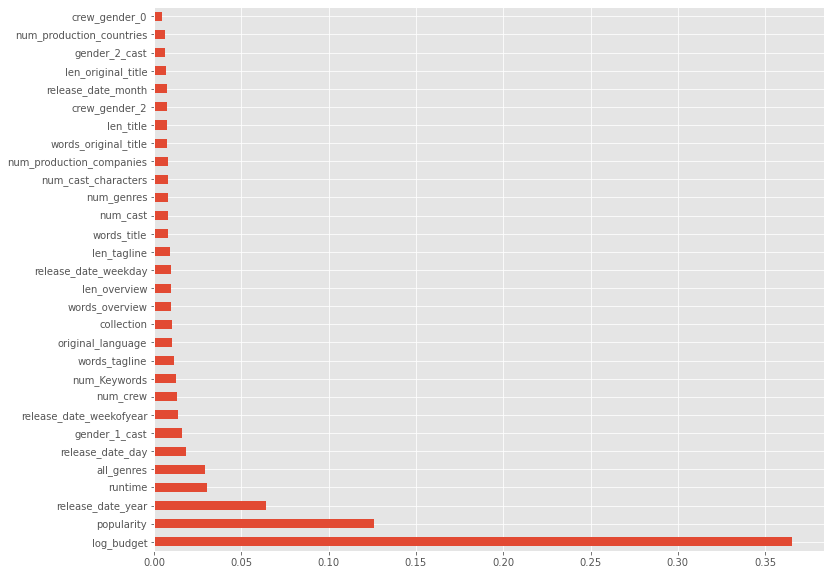

In [97]:
ax = plt.figure(figsize=(12, 10))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(30).plot(kind='barh')

output feature is highly dependent on log_budget, populrity and release_date_year

**Ada boost**

In [98]:
ada = AdaBoostRegressor()
ada.fit(X_train, Y_train)
mean_squared_error(ada.predict(X_valid), Y_valid), mean_absolute_error(ada.predict(X_valid), Y_valid)

(5.867178411222688, 1.7421259267356193)

**Gradient Boosting regression**

In [99]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
mean_squared_error(reg.predict(X_valid), Y_valid), mean_absolute_error(reg.predict(X_valid), Y_valid)

(9.79120583130394, 2.3367323588315476)

**XGB Regressor**

In [100]:
xgb = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xgb, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 1.477 (0.098)


**LGBM Regressor**

In [101]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb = LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
lgb.fit(X_train, Y_train)
mean_squared_error(lgb.predict(X_valid), Y_valid), mean_absolute_error(lgb.predict(X_valid), Y_valid)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2


(4.68517846569435, 1.3886274055639092)

In [102]:
eli5.show_weights(lgb, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.3531,log_budget
0.1368,popularity
0.0661,release_date_year
0.0346,runtime
0.0343,all_genres
0.0216,release_date_day
0.0197,release_date_weekofyear
0.0181,num_crew
0.0179,num_Keywords
0.0168,num_cast


RandomForest and LGBMRegressor perform best as per there mean absolute error